In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Using a custom agent implementation

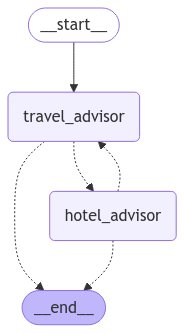

In [2]:
from typing_extensions import Literal

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command





# Define a helper for each of the agent nodes to call


@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    # (See the paragraph above)
    return


@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return


def travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


def hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", travel_advisor)
builder.add_node("hotel_advisor", hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [4]:
for chunk in graph.stream(
    {"messages": [("user", "i wanna go somewhere warm in the caribbean")]}
):
    pretty_print_messages(chunk)

Update from node travel_advisor:


================================== Ai Message ==================================

The Caribbean is a fantastic choice for warm weather and beautiful scenery! Here are a few destinations you might consider:

1. **Jamaica**: Known for its stunning beaches, reggae music, and vibrant culture. You can explore the Blue Mountains or relax on Seven Mile Beach in Negril.

2. **Barbados**: Famous for its white sandy beaches and crystal-clear waters. Visit the historic capital, Bridgetown, or enjoy water sports at the west coast beaches.

3. **St. Lucia**: Renowned for its dramatic landscapes, including the Pitons. Enjoy hiking, snorkeling, and relaxing in hot springs.

4. **Bahamas**: With over 700 islands, you can find everything from bustling Nassau to the serene Exumas. Perfect for beach lovers and divers.

5. **Dominican Republic**: Offers a mix of beautiful beaches, rich history, and vibrant nightlife. Punta Cana is popular for resorts, while Santo Domingo

In [5]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    }
):
    pretty_print_messages(chunk)

Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_646t4wCmNOzsdTix3O4XRX3w)
 Call ID: call_646t4wCmNOzsdTix3O4XRX3w
  Args:
================================= Tool Message =================================

Successfully transferred


Update from node hotel_advisor:


================================== Ai Message ==================================

Could you please specify which Caribbean destination you'd like recommendations for?




# Using with a prebuilt ReAct agent

In [6]:
import random
from typing_extensions import Literal


@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]

In [7]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

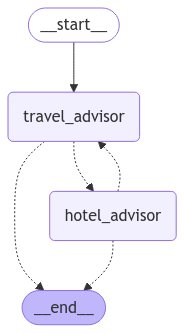

In [9]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


# Define travel advisor ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    state_modifier=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    return travel_advisor.invoke(state)


# Define hotel advisor ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    state_modifier=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    return hotel_advisor.invoke(state)


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)

Update from subgraph travel_advisor:


Update from node agent:


================================== Ai Message ==================================
Tool Calls:
  get_travel_recommendations (call_nSQSMq2DJwDjFSq0XxqYPHR9)
 Call ID: call_nSQSMq2DJwDjFSq0XxqYPHR9
  Args:
  transfer_to_hotel_advisor (call_TR31ZZmCuk4ZGHBCkJle27XO)
 Call ID: call_TR31ZZmCuk4ZGHBCkJle27XO
  Args:


Update from subgraph travel_advisor:


Update from node tools:


================================= Tool Message =================================
Name: get_travel_recommendations

turks and caicos




ValueError: Found AIMessages with tool_calls that do not have a corresponding ToolMessage. Here are the first few of those tool calls: [{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'call_TR31ZZmCuk4ZGHBCkJle27XO', 'type': 'tool_call'}].

Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage (result of a tool invocation to return to the LLM) - this is required by most LLM providers.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CHAT_HISTORY